# Yelp Dataset Analysis - Formula of a Good Italian Restaurant

# A: Read the dataset

In [4]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
import numpy as np
import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from matplotlib.patches import Polygon
import pandas.io.sql as pdSQL
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pylab
import pymysql
import csv
from scipy.misc import imread
import geopandas as gp
import pysal

In [230]:
with open('business.json', 'r') as f: 
    data = f.readlines()

# load business file
business = pd.concat([json_normalize(json.loads(j)) for j in data])

In [231]:
def load_data(filepath):
    data = []
    with open(filepath, encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line.rstrip()))

    return data

In [232]:
# load review file
data = load_data('review.json')
review = pd.DataFrame.from_dict(data)

In [7]:
# load tip file
data = load_data('tip.json')
tip = pd.DataFrame.from_dict(data)

# B: Location Analysis -- find the fit state to operate the Italian restaurant

### Convert business dataframe to csv

In [3]:
state_list = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [4]:
# create a subset with only three columns - categories, state and stars
business_state = business.loc[:,("categories", "state", "stars")]

In [5]:
business_state.head()

,categories,state,stars
0,"[Shopping, Shopping Centers]",OH,2.0
1,"[Food, Soul Food, Convenience Stores, Restaura...",NC,4.5
2,"[Food, Coffee & Tea]",ON,4.5
3,"[Professional Services, Matchmakers]",AZ,3.0
4,"[Sandwiches, Restaurants]",AZ,4.5


In [6]:
# export data frame to csv
business_state.to_csv('business_state.csv', sep=',',index = False)

### Find the states where there are Italian restaurants

In [233]:
# create a subset of business with only Italian restaurants
italian = business[business.categories.map(lambda x: 'Italian' in x)]

In [8]:
italian_state = italian.loc[:,("state", "stars")]

In [9]:
italian_state = italian_state[italian_state['state'].isin(state_list)]

In [10]:
italian_state.groupby('state')["state"].nunique()

state
AZ    1
IL    1
NC    1
NV    1
NY    1
OH    1
PA    1
SC    1
WI    1
Name: state, dtype: int64

### Connect to mysql, and load the business_state data to mysql workbench 

In [11]:
import pymysql
# connect to mysql
conn = pymysql.connect('localhost', 'root', '123456', 'sys')
cursor = conn.cursor()

In [12]:
sql = '''
        DROP TABLE IF EXISTS business_state;
        
        CREATE TABLE business_state(
        categories TEXT,
        state TEXT,
        stars FLOAT
        );
    '''
cursor.execute(sql)

0

In [15]:
# insert into table business_state from csv file
with open('business_state.csv') as csvfile:  
    sp = csv.DictReader(csvfile)  
    for row in sp:
        sql = '''
        INSERT INTO business_state
        VALUES ('%s','%s',%f)'''\
        %(row['categories'],row['state'],float(row['stars']))
        cursor.execute(sql)
        conn.commit()

In [146]:
# find out the average star and count of all restaurants in different states of America
restaurant_state_avg = pdSQL.read_sql('''
SELECT state, AVG(stars) AS avg_star, count(*) AS count
FROM business_state
WHERE categories LIKE '%Restaurant%'
AND (state LIKE 'AZ'
OR state LIKE 'IL'
OR state LIKE 'NC'
OR state LIKE 'NV'
OR state LIKE 'OH'
OR state LIKE 'PA'
OR state LIKE 'SC'
OR state LIKE 'WI')
GROUP BY state
ORDER BY avg_star, count(*) DESC
''', conn) 
print (restaurant_state_avg)

  state  avg_star  count
0    SC  3.303483    201
1    IL  3.327759    598
2    NC  3.382101   3626
3    AZ  3.410864  10226
4    OH  3.432196   4513
5    NV  3.442056   6886
6    WI  3.452557   1486
7    PA  3.504075   3436


In [147]:
# find out the average star and count of all Italian restaurants in different states of America
italian_state_avg = pdSQL.read_sql('''
SELECT state, AVG(stars) AS avg_star, count(*) AS count
FROM business_state
WHERE categories LIKE '%italian%'
AND (state LIKE 'AZ'
OR state LIKE 'IL'
OR state LIKE 'NC'
OR state LIKE 'NV'
OR state LIKE 'OH'
OR state LIKE 'PA'
OR state LIKE 'SC'
OR state LIKE 'WI')
GROUP BY state
ORDER BY avg_star, count(*) DESC
''', conn) 
print (italian_state_avg)

  state  avg_star  count
0    IL  3.292683     41
1    SC  3.305556     18
2    WI  3.318966    116
3    NC  3.381526    249
4    OH  3.454787    376
5    PA  3.479950    399
6    NV  3.502174    460
7    AZ  3.530488    820


### Connect with map

In [105]:
# create a dictionary with state information
states_list = {
        #'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        #'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        #'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        #'GU': 'Guam',
        #'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        #'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        #'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        #'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        #'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        #'PR': 'Puerto Rico',
        #'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        #'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [27]:
# load the shp file containing the information of states boundary
state_boundary = gp.GeoDataFrame.from_file('gz_2010_us_040_00_500k.shp')

In [108]:
# make the data frame only include states that we want to show
state_boundary = state_boundary[state_boundary.NAME.isin(states_list.values())]

In [150]:
restaurant_state_avg = restaurant_state_avg[restaurant_state_avg["state"].isin(states_list.keys())]
restaurant_state_avg["state"].replace(states_list, inplace=True)

In [152]:
# change the state name to full name
restaurant_state_avg = restaurant_state_avg.rename(index = str, columns = {'state':'NAME'})

In [153]:
restaurant_state_avg = gp.GeoDataFrame(restaurant_state_avg)

In [180]:
restaurant_merge = state_boundary.merge(restaurant_state_avg, on = 'NAME', how='left')

In [192]:
restaurant_merge['avg_star'] = restaurant_merge['avg_star'].fillna(0)
restaurant_merge['count'] = restaurant_merge['count'].fillna(0)

In [157]:
# change the state name to full name
italian_state_avg = italian_state_avg[italian_state_avg["state"].isin(states_list.keys())]
italian_state_avg["state"].replace(states_list, inplace=True)

In [158]:
italian_state_avg = italian_state_avg.rename(index = str, columns = {'state':'NAME'})

In [159]:
italian_state_avg = gp.GeoDataFrame(italian_state_avg)

In [160]:
italian_merge = state_boundary.merge(italian_state_avg, on = 'NAME', how='left')

In [194]:
italian_merge['avg_star'] = italian_merge['avg_star'].fillna(0)
italian_merge['count'] = italian_merge['count'].fillna(0)

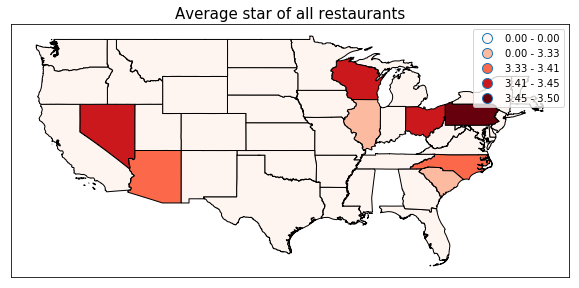

In [189]:
# draw a figure showing the average rating of all restaurants
restaurant_merge.plot('avg_star', edgecolor='black', cmap = 'Reds', figsize = (10,20), scheme='fisher_jenks', legend = True)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.title('Average star of all restaurants', fontsize=15)

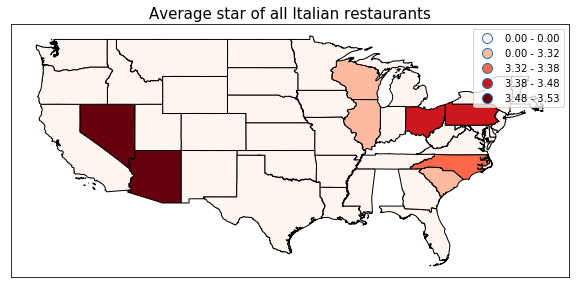

In [190]:
# draw a figure showing the average rating of all Italian restaurants
italian_merge.plot('avg_star', edgecolor='black', cmap = 'Reds', scheme='fisher_jenks', figsize = (10,20), legend = True)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.title('Average star of all Italian restaurants', fontsize=15)

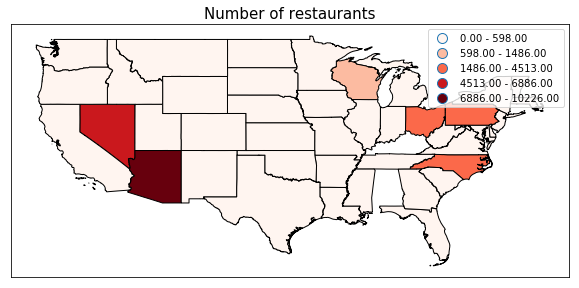

In [193]:
# draw a figure showing the number of all restaurants
restaurant_merge.plot('count', edgecolor='black', cmap = 'Reds', figsize = (10,20), scheme='fisher_jenks', legend = True)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.title('Number of restaurants', fontsize=15)

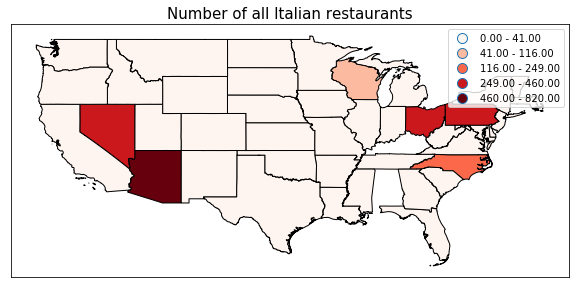

In [195]:
# draw a figure showing the number of all Italian restaurants
italian_merge.plot('count', edgecolor='black', cmap = 'Reds', scheme='fisher_jenks', figsize = (10,20), legend = True)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.title('Number of all Italian restaurants', fontsize=15)

### Conclusion: 
the number of all restaurants and Italian restaurants in AZ are the highest. Moreover, the average star of  Italian restaurants in AZ is higher than that of all  restaurants in AZ. That is, people in AZ have great impression on Italian restaurants, thus being more likely to give high rate to Italian restaurants. Therefore, we suggest opening Italian restaurants in AZ. :D

# C: Data Subset -- find good (star > 4) and bad (star < 3) Italian restaurants

We define Italian restaurants that are rated over four stars as good Italian restaurants. 

In [206]:
g_italian = italian[italian.stars > 4]

We define Italian restaurants that are rated less than three stars as bad Italian restaurants.

In [207]:
b_italian = italian[italian.stars < 3]

# D: Attribute Analysis -- find important attributes to operate a good Italian restaurant 

### Find the category columns

In [47]:
catelist=[]
for col, x in italian.iloc[0,:].iteritems():
    if(italian[col].dtype.name == 'object'):
        catelist.append(col)

### Remove the category columns that have over 25% (1000) null values or useless in our further analysis

In [48]:
# find columns that have more than 1000 null values
rm_cate=[]
for i in catelist:
    if italian[i].isnull().sum()>1000:
        rm_cate.append(i)

In [55]:
# remove thses columns
cate=list(set(catelist)-set(rm_cate))
cate

['attributes.BusinessParking.valet',
 'attributes.Ambience.upscale',
 'attributes.BusinessAcceptsCreditCards',
 'business_id',
 'attributes.Ambience.intimate',
 'categories',
 'attributes.Ambience.classy',
 'name',
 'attributes.HasTV',
 'attributes.BusinessParking.validated',
 'attributes.BusinessParking.street',
 'attributes.RestaurantsDelivery',
 'attributes.GoodForMeal.dessert',
 'neighborhood',
 'attributes.GoodForMeal.breakfast',
 'attributes.Ambience.casual',
 'attributes.RestaurantsAttire',
 'attributes.GoodForMeal.brunch',
 'latitude',
 'attributes.GoodForKids',
 'attributes.GoodForMeal.latenight',
 'attributes.Alcohol',
 'city',
 'postal_code',
 'attributes.RestaurantsTakeOut',
 'attributes.RestaurantsGoodForGroups',
 'attributes.RestaurantsReservations',
 'hours.Saturday',
 'attributes.BusinessParking.garage',
 'longitude',
 'state',
 'attributes.Ambience.romantic',
 'attributes.GoodForMeal.dinner',
 'attributes.RestaurantsTableService',
 'hours.Wednesday',
 'hours.Friday',
 

In [56]:
# remove columns that are useless in our future analysis
cate.remove('hours.Saturday')
cate.remove('hours.Tuesday')
cate.remove('business_id')
cate.remove('hours.Wednesday')
cate.remove('postal_code')
cate.remove('latitude')
cate.remove('hours.Friday')
cate.remove('city')
cate.remove('hours.Thursday')
cate.remove('longitude')
cate.remove('neighborhood')
cate.remove('name')
cate.remove('address')
cate.remove('categories')
cate.remove('state')
cate.remove('attributes.RestaurantsAttire')
cate.remove('attributes.Alcohol')

### Important attributes criteria: 
1. The proportion of true value in good Italian restaurants and of that in bad Italian restaurants fall on the different sides of the average line. (average line: the proportion of true value in all Italian restaurants)
<br><br>
2. The difference between two proportions mentioned above is greater than 0.15 time of the smaller one.
<br><br>
3. At least one proportion is greater than 0.05.

In [57]:
# calculate mean values of attrirbutes of all Italian restaurants
italian_avg = pd.DataFrame(np.zeros([1, len(cate)]), columns=cate)
for i in range(0, len(cate)):
    italian_avg.iloc[0,i]=np.mean(italian[cate[i]])

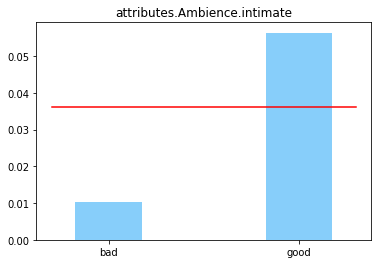

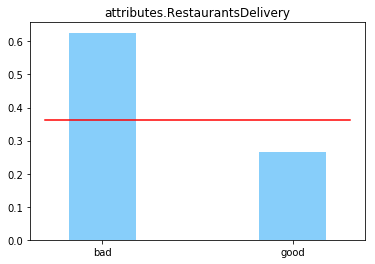

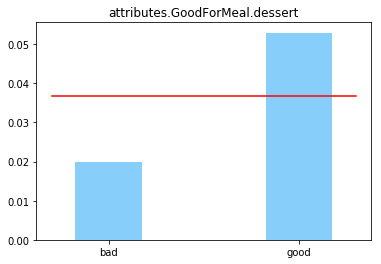

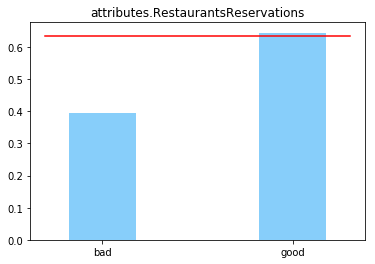

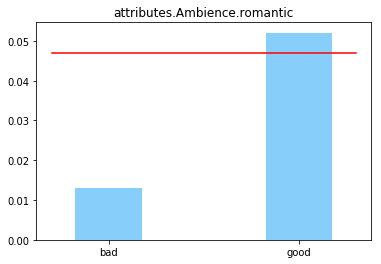

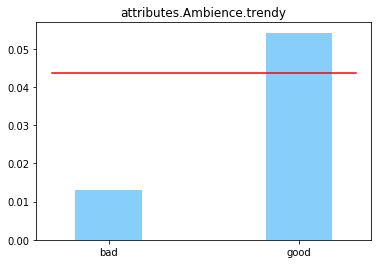

In [58]:
for column in cate:
    good_avg = np.mean(g_italian[column])
    bad_avg = np.mean(b_italian[column])
    if ((good_avg-list(italian_avg[column]))*(bad_avg-list(italian_avg[column])) < 0 
        and (good_avg>1.15*bad_avg or bad_avg > 1.15*good_avg) and (good_avg > 0.05 or bad_avg > 0.05)):
        # plot bars that represent The proportion of true value in good and bad Italian restaurants 
        plt.bar([0,1], [bad_avg, good_avg], width = 0.35, facecolor = 'lightskyblue')
        plt.title(column)
        plt.xticks([0,1], ['bad', 'good'])
        # the red line represents the 'True' proportion of all Italian restaurants
        plt.plot([-0.3, 1.3], [italian_avg[column], italian_avg[column]], 'r-')
        plt.show()

### Conclusion: 
The secrets of good Italian restaurants are listed below:
1. Have initimate ambience
2. Have romantic ambience
3. Have trendy ambience
4. Offer reservation service
5. Provide good dessert
6. Offer no delivery service

# E: Wordcloud Analysis -- find important information for a good/bad Italian restaurant  

### Based on review and tip separately, create wordcloud for good and bad Italian restaurants 

- Review of good Italian restaurants 

In [234]:
good_id = list(g_italian['business_id'])
bad_id = list(b_italian['business_id'])

In [235]:
# create subsets that only include review of good or bad Italian restaurants
good_review = review[review['business_id'].isin(good_id)]
bad_review = review[review['business_id'].isin(bad_id)]

In [62]:
# combine all good review text together into one string
good_text = []
for i in good_review.iloc[:,6]:
    good_text.append(i.lower())
text = ''
for i in range(0,len(good_text)):
    text = text + good_text[i]

In [63]:
coloring = imread('pizza.jpg')

In [64]:
wc = WordCloud(background_color="white", max_words=100, mask=coloring, stopwords = STOPWORDS, max_font_size=80)

In [65]:
wc.generate(text)

In [66]:
image_colors = ImageColorGenerator(coloring)

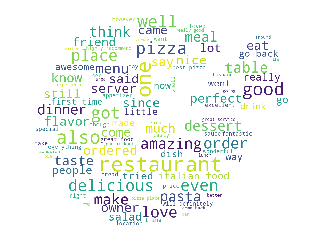

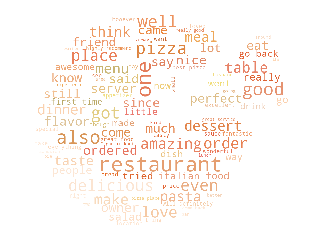

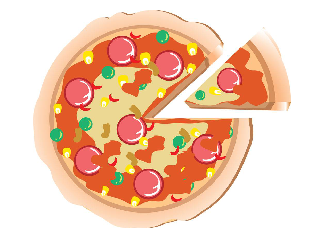

In [67]:
# plot the wordcloud figure for good review
plt.imshow(wc)
plt.axis("off")
plt.figure()

plt.imshow(wc.recolor(color_func = image_colors))
plt.axis("off")
plt.figure()

plt.imshow(coloring, cmap = plt.cm.gray)
plt.axis("off")
plt.show()

In [68]:
wc.to_file('good_wordcloud.png')

- Review of bad Italian restaurants 

In [69]:
# combine all bad review text together into one string
bad_text=[]
for i in bad_review.iloc[:,6]:
    bad_text.append(i.lower())
text=''
for i in range(0,len(bad_text)):
    text=text+bad_text[i]

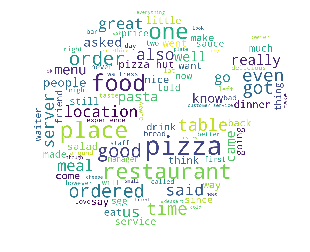

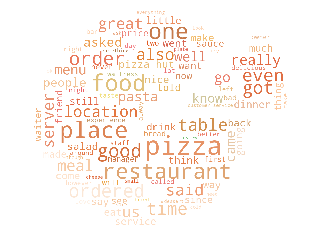

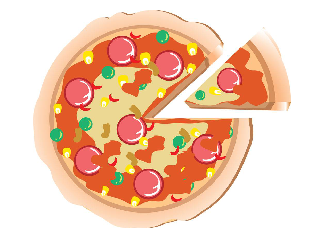

In [70]:
# plot the wordcloud figure for bad review
wc = WordCloud(background_color="white", max_words=100, mask=coloring, stopwords=STOPWORDS, max_font_size=100)
wc.generate(text)
image_colors = ImageColorGenerator(coloring)
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(wc.recolor(color_func=image_colors))
plt.axis("off")
plt.figure()
plt.imshow(coloring, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [71]:
wc.to_file('bad_wordcloud.png')

- Tip of good Italian restaurants 

In [72]:
good_tip=tip[tip['business_id'].isin(good_id)]
bad_tip=tip[tip['business_id'].isin(bad_id)]

In [73]:
# combine all good tip text together into one string
good_text=[]
for i in good_tip.iloc[:,3]:
    good_text.append(i.lower())

In [74]:
text=''
for i in range(0,len(good_text)):
    text=text+good_text[i]

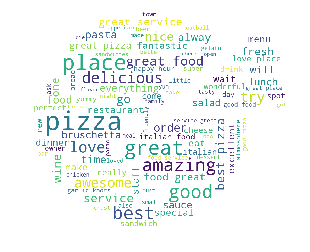

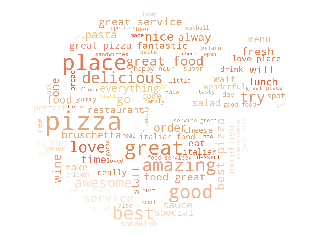

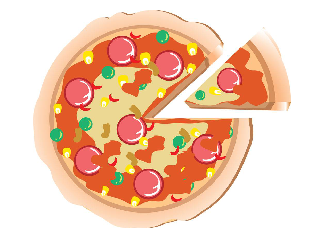

In [75]:
# plot the wordcloud figure for good tip
wc = WordCloud(background_color="white", max_words=100, mask=coloring, stopwords=STOPWORDS, max_font_size=100)
wc.generate(text)
image_colors = ImageColorGenerator(coloring)
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(wc.recolor(color_func=image_colors))
plt.axis("off")
plt.figure()
plt.imshow(coloring, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [76]:
wc.to_file('good_tip.png')

- Tip of bad Italian restaurants 

In [77]:
# combine all bad tip text together into one string
bad_text=[]
for i in bad_tip.iloc[:,3]:
    bad_text.append(i.lower())
text=''
for i in range(0,len(bad_text)):
    text=text+bad_text[i]

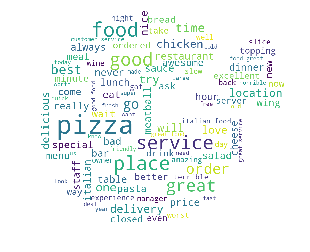

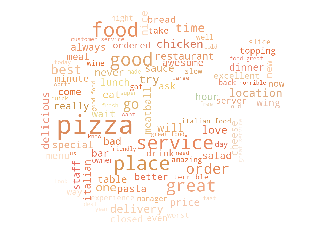

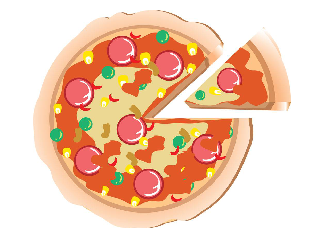

In [78]:
# plot the wordcloud figure for bad tip
wc = WordCloud(background_color="white", max_words=100, mask=coloring, stopwords=STOPWORDS, max_font_size=100)
wc.generate(text)
image_colors = ImageColorGenerator(coloring)
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(wc.recolor(color_func=image_colors))
plt.axis("off")
plt.figure()
plt.imshow(coloring, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [79]:
wc.to_file('bad_tip.png')

### Conclusion:
We find some key words for Italian restaurants. 
* Food: pasta, pizza, garlic knots, bruschetta, appetizer, gelato, meatball, and so on. 
* Operation: delivery, happy hour, patio, price, dinner, wait, service, and so on.

Next, we develop some futher analysis of word frequency to find out some aspects that operators can avoid or persue to contribute to a good Italian restaurant.

# F: Word Frequency Analysis -- find the elements that a good Italian restaurant operator should follow or avoid

We choose 20 key words from wordcloud. Then we calculate the frequency of these 20 words in reviews for either good or bad Italian restaurants. Furthermore, we use scatter plot to visualize the frequencies. Next, we divide the figure into three parts. Each part represents different meaning.

* Those falling in the part close to x-axis, meaning that they have high frequency in good Italian restaurant reviews but barely appear in bad Italian restaurant reviews, can be considered as the keys to operate a good Italian restaurant.
* Those falling in the middle part of the figure, meaning that they have high frequency in both good and bad Italian restaurant reviews, are the base line to operate a plain Italian restaurant.
* Those falling in the part close to y-axis, meaning that they have high frequency in bad Italian restaurant reviews but barely appear in good Italian restaurant reviews, should be avoided.


In [236]:
g_italian_review = good_review[['text']]

In [237]:
# lowercase the review text of good Italian restaurants
g_italian_review['text_lower'] = g_italian_review['text'].apply(lambda x: x.lower())

/Users/bobo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [238]:
b_italian_review = bad_review[['text']]

In [239]:
# lowercase the review text of bad Italian restaurants
b_italian_review['text_lower'] = b_italian_review['text'].apply(lambda x: x.lower())

/Users/bobo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [240]:
# we pick some words from wordcloud figures to count word frequencies
word = ['garlic knots', 'bruschetta', 'appetizer', 'gelato', 'happy hour', 'love place', 'patio', 
        'meatball', 'chicken', 'bar', 'delivery', 'topping',
       'pasta', 'salad', 'dinner', 'price', 'dessert']

In [241]:
# create a dataframe that contains three columns
d = {'word': ['garlic knots', 'bruschetta', 'appetizer', 'gelato', 'happy hour', 'love place', 'patio', 
        'meatball', 'chicken', 'bar', 'delivery', 'topping',
       'pasta', 'salad', 'dinner', 'price', 'dessert'], 
     'good_restaurant': np.nan, 'bad_restaurant': np.nan}

df = pd.DataFrame(data=d)
df = df[df.columns[::-1]]

In [242]:
# we define word frequency as the number of reviews that contain this word divided by total number of reviews.
for i in range(0, 17):
    df.iloc[i, 1] = len(g_italian_review[g_italian_review.text_lower.str.contains(word[i])])/len(g_italian_review)
    df.iloc[i, 2] = len(b_italian_review[b_italian_review.text_lower.str.contains(word[i])])/len(b_italian_review)

In [243]:
df

,word,good_restaurant,bad_restaurant
0,garlic knots,0.030454,0.002133
1,bruschetta,0.069043,0.008267
2,appetizer,0.061818,0.051556
3,gelato,0.027323,0.006489
4,happy hour,0.025262,0.006933
5,love place,0.000134,0.000000
6,patio,0.037144,0.025067
7,meatball,0.051274,0.042667
8,chicken,0.085662,0.114844
9,bar,0.088124,0.120444


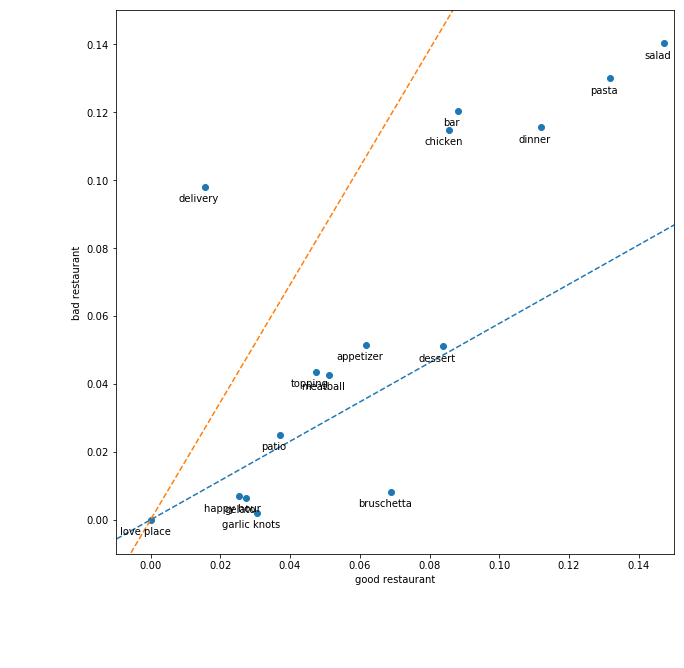

In [246]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df.good_restaurant, df.bad_restaurant)
plt.plot([-1,1], [-0.578, 0.578], linestyle='--')
plt.plot([-0.578,0.578], [-1, 1], linestyle='--')
plt.xlabel("good restaurant")
plt.ylabel("bad restaurant")
pylab.xlim([-0.01, 0.15])
pylab.ylim([-0.01, 0.15])
    
for X, Y, Z in zip(df.good_restaurant, df.bad_restaurant, df.word):
    ax.annotate('{}'.format(Z), xy=(X,Y), xytext=(-6, -15),  ha='center',
                textcoords='offset points')

In [247]:
word2 = ['pizza', 'service', 'friend']

In [248]:
d2 = {'word': ['pizza', 'service', 'friend'], 
     'good_restaurant': np.nan, 'bad_restaurant': np.nan}

df2 = pd.DataFrame(data=d2)
df2 = df2[df2.columns[::-1]]

In [249]:
for i in range(0, 3):
    df2.iloc[i, 1] = len(g_italian_review[g_italian_review.text_lower.str.contains(word2[i])])/len(g_italian_review)
    df2.iloc[i, 2] = len(b_italian_review[b_italian_review.text_lower.str.contains(word2[i])])/len(b_italian_review)

In [250]:
df2 

,word,good_restaurant,bad_restaurant
0,pizza,0.380379,0.390844
1,service,0.326483,0.369778
2,friend,0.262364,0.184356


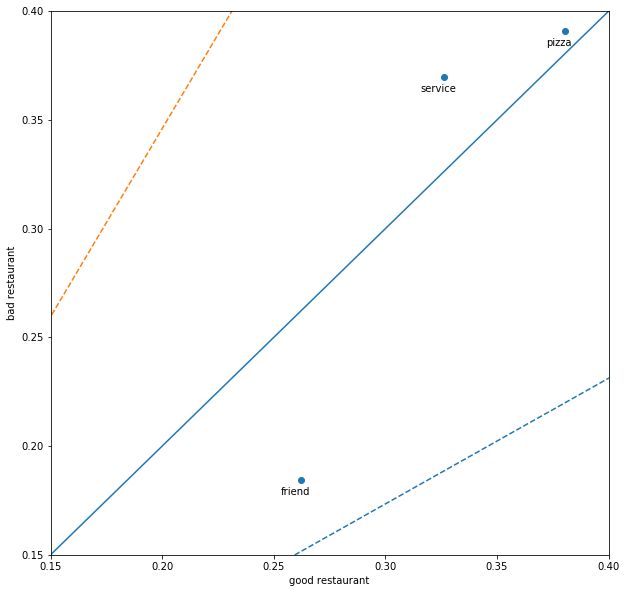

In [251]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import pylab

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df2.good_restaurant, df2.bad_restaurant)
line = mlines.Line2D([0, 1], [0, 1])
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlabel("good restaurant")
plt.ylabel("bad restaurant")
plt.plot([0,1], [0, 0.578], linestyle='--')
plt.plot([0,0.578], [0, 1], linestyle='--')
pylab.xlim([0.15, 0.4])
pylab.ylim([0.15, 0.4])


for X, Y, Z in zip(df2.good_restaurant, df2.bad_restaurant, df2.word):
    ax.annotate('{}'.format(Z), xy=(X,Y), xytext=(-6, -15),  ha='center',
                textcoords='offset points')

### Conclusion:
We can conclude the secrets to operate a good Italian restaurant:
* Provide happy hour service and good garlic knots, bruschetta, and gelato
* Be careful with topping, appetizer, dessert, meatball, chicken, pasta, salad, and pizza. Also, pay attention on service, dinner time, bar, patio and customers for friend union. 
* Never attempt to provide delivery service

# G: Check-in Time Analysis -- Find the fit opening time

In [198]:
# load check-in file
with open('checkin.json', 'r') as f:
    data = f.readlines()
checkin=pd.concat([json_normalize(json.loads(j)) for j in data])

In [199]:
# fill null values with 0
checkin = checkin.fillna(0)

In [200]:
weekday=['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']

In [201]:
# calculate the number of check-in customers in each day of a week
for i in range(0,7):
    checkin[weekday[i]] = checkin.iloc[:, i*24+1]
    for j in range(1,24):
        checkin[weekday[i]] = checkin[weekday[i]] + checkin.iloc[:, i*24+j+1]

In [202]:
hour = [0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 20, 21, 22, 23, 2, 3, 4, 5, 6, 7, 8, 9]

In [203]:
# calculate the number of check-in customers in each hour of a day
for i in range(0,24):
    checkin[hour[i]] = checkin.iloc[:, i+1]
    for j in range(1,7):
        checkin[hour[i]] = checkin[hour[i]] + checkin.iloc[:, j*24+i+1]

In [209]:
# create subsets that contain the number of check-in customers in good or bad Italian restaurants
good_checkin = checkin[checkin['business_id'].isin(good_id)][['business_id']+weekday+hour]
bad_checkin = checkin[checkin['business_id'].isin(bad_id)][['business_id']+weekday+hour]

In [210]:
weekday_o = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [212]:
# create a subset that only contains the information of restaurants
restaurant = business[business.categories.map(lambda x: 'Restaurants' in x)]

In [252]:
restaurant_id = list(restaurant['business_id'])
italian_id = list(italian['business_id'])

In [253]:
restaurant_checkin = checkin[checkin['business_id'].isin(restaurant_id)][['business_id']+weekday+hour]
italian_checkin = checkin[checkin['business_id'].isin(italian_id)][['business_id']+weekday+hour]

In [254]:
bad_ck_avg_d=[]
good_ck_avg_d=[]
r_ck_avg_d=[]
i_ck_avg_d=[]
for i in weekday_o:
    bad_ck_avg_d.append(np.mean(bad_checkin[i]))
    good_ck_avg_d.append(np.mean(good_checkin[i]))
    r_ck_avg_d.append(np.mean(restaurant_checkin[i]))
    i_ck_avg_d.append(np.mean(italian_checkin[i]))

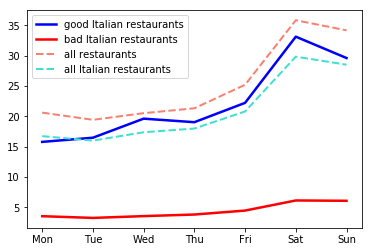

In [255]:
plt.plot(range(0,7), good_ck_avg_d, color="blue", linewidth=2.5, linestyle="-", label="good Italian restaurants")
plt.plot(range(0,7), bad_ck_avg_d, color="red", linewidth=2.5, linestyle="-", label="bad Italian restaurants")
plt.plot(range(0,7), r_ck_avg_d, color="salmon", linewidth=2., linestyle="--", label="all restaurants")
plt.plot(range(0,7), i_ck_avg_d, color="turquoise", linewidth=2., linestyle="--", label="all Italian restaurants")
plt.xticks(range(0,7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(loc='upper left')
plt.show()

In [256]:
bad_ck_avg_h=[]
good_ck_avg_h=[]
r_ck_avg_h=[]
i_ck_avg_h=[]
for i in range(0,24):
    bad_ck_avg_h.append(np.mean(bad_checkin[i]))
    good_ck_avg_h.append(np.mean(good_checkin[i]))
    r_ck_avg_h.append(np.mean(restaurant_checkin[i]))
    i_ck_avg_h.append(np.mean(italian_checkin[i]))

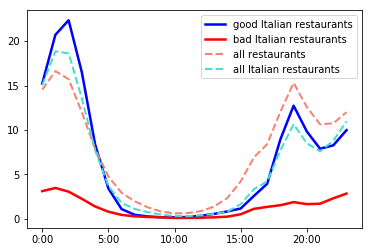

In [257]:
plt.plot(range(0,24), good_ck_avg_h, color="blue", linewidth=2.5, linestyle="-", label="good Italian restaurants")
plt.plot(range(0,24), bad_ck_avg_h, color="red", linewidth=2.5, linestyle="-", label="bad Italian restaurants")
plt.plot(range(0,24), r_ck_avg_h, color="salmon", linewidth=2, linestyle="--", label="all restaurants")
plt.plot(range(0,24), i_ck_avg_h, color="turquoise", linewidth=2, linestyle="--", label="all Italian restaurants")
plt.xticks([0, 5, 10, 15, 20], ['0:00', '5:00', '10:00', '15:00', '20:00'])
plt.legend(loc='upper right')
plt.show()

### Conclusion:

Based on the analysis of customer flow in a week, we find that there are more customers patronizing Italian restaurants on weekends than that on weekdays. Therefore, we suggest providing happy hour and other discounts on weekdays.
What's more, we can see that there are two peaks of the flow of people who patronize an Italian restaurant during one day -- that is dinner time and midnight. Therefore, we highly recommend opening the Italian restaurant from 6 pm to 5 am.

## Secrets of a good Italian restaurant:

1. For location, Arizona state is the best place to open an Italian restaurant.
2. For atmosphere, create a blend of romantic, intimate, and trendy atmosphere, targeting dating people and friends. 
3. For food, provide delicate Italian specialties: garlic knots, bruschetta, and gelato. Pay attention to pizza, topping, appetizer, dessert, meatball, chicken, pasta, and salad.
4. For service, offer patio, bar, and reservation service; provide happy hour on weekdays. AVOID delivery service. 
5. For opening hour, 6 pm - 5 am is a good choice.